In [2]:
import utils
import metrics
import CNNLSTMModel
import ConvLSTM2DModel

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

LUCKY_NUMBER = 2
TARGET_SIZE = (64, 64) # For no compression choose -1
TARGET_SLICES = 304

PHOTOS_PATH = "E:\\images\\"
MASK_PATH = "E:\\masks\\"

In [ ]:
print("GPUs Available: ",tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy

# Set the policy to mixed precision
set_global_policy('mixed_float16')


Prepare data

In [ ]:
np.random.seed(LUCKY_NUMBER)
batch_size = 1
epochs = 20

scan_names = [file[:8] for file in os.listdir(PHOTOS_PATH) if file.endswith(".nii.gz")]
train, val, test = utils.split_train_val_test(scan_names, 0.7, 0.15, 0.15)
print(f"Training data size: {len(train)}, Validation data size: {len(val)}, Test data size: {len(test)}")

print(train)
train_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, train)
val_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, val)


model = CNNLSTMModel.create_cnn_lstm_model(image_shape=TARGET_SIZE, num_slices=50)
#model = ConvLSTM2DModel.create_cnn_convlstm2d_model(image_shape=TARGET_SIZE, num_slices=50)
model.summary()

print(model.output_shape)

Training data size: 98, Validation data size: 21, Test data size: 21
['ZEBY_183', 'ZEBY_218', 'ZEBY_107', 'ZEBY_202', 'ZEBY_209', 'ZEBY_130', 'ZEBY_160', 'ZEBY_122', 'ZEBY_117', 'ZEBY_194', 'ZEBY_128', 'ZEBY_136', 'ZEBY_182', 'ZEBY_178', 'ZEBY_232', 'ZEBY_224', 'ZEBY_200', 'ZEBY_201', 'ZEBY_185', 'ZEBY_124', 'ZEBY_179', 'ZEBY_227', 'ZEBY_119', 'ZEBY_162', 'ZEBY_175', 'ZEBY_102', 'ZEBY_157', 'ZEBY_120', 'ZEBY_206', 'ZEBY_110', 'ZEBY_161', 'ZEBY_135', 'ZEBY_141', 'ZEBY_111', 'ZEBY_199', 'ZEBY_187', 'ZEBY_127', 'ZEBY_133', 'ZEBY_237', 'ZEBY_163', 'ZEBY_158', 'ZEBY_174', 'ZEBY_238', 'ZEBY_118', 'ZEBY_190', 'ZEBY_240', 'ZEBY_198', 'ZEBY_109', 'ZEBY_214', 'ZEBY_223', 'ZEBY_150', 'ZEBY_180', 'ZEBY_230', 'ZEBY_228', 'ZEBY_220', 'ZEBY_151', 'ZEBY_177', 'ZEBY_153', 'ZEBY_181', 'ZEBY_167', 'ZEBY_229', 'ZEBY_184', 'ZEBY_233', 'ZEBY_171', 'ZEBY_147', 'ZEBY_169', 'ZEBY_189', 'ZEBY_170', 'ZEBY_222', 'ZEBY_159', 'ZEBY_134', 'ZEBY_207', 'ZEBY_139', 'ZEBY_204', 'ZEBY_152', 'ZEBY_208', 'ZEBY_143', 'ZEBY_

C:\Users\Kacper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 50, 64, 64, 16) │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 50, 32, 32, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 50, 32, 32, 32) │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 50, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 50, 16, 16, 64) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 50, 8, 8, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 50, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 50, 16, 16, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 50, 32, 32, 32) │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 50, 64, 64, 16) │         4,624 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 50, 64, 64, 1)  │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,753 (1.32 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

(None, 50, 64, 64, 1)


Train model

In [ ]:
model.layers[9].input.shape

In [4]:
model.fit(
    train_gen, 
    batch_size=1,
    steps_per_epoch=len(train)//batch_size,
    validation_data=val_gen,
    validation_steps=len(val)//batch_size,
    epochs=epochs)

ZEBY_183_0000.nii.gz: (50, 64, 64, 1), ZEBY_183.nii.gz: (50, 64, 64, 1)
Batch ready: scans shape (1, 50, 64, 64, 1), masks shape (1, 50, 64, 64, 1)
ZEBY_218_0000.nii.gz: (50, 64, 64, 1), ZEBY_218.nii.gz: (50, 64, 64, 1)
Batch ready: scans shape (1, 50, 64, 64, 1), masks shape (1, 50, 64, 64, 1)
Epoch 1/20
 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:06 695ms/step - dice_coefficient: 0.0242 - jaccard_index: 0.0131 - loss: 0.9758ZEBY_107_0000.nii.gz: (50, 64, 64, 1), ZEBY_107.nii.gz: (50, 64, 64, 1)
Batch ready: scans shape (1, 50, 64, 64, 1), masks shape (1, 50, 64, 64, 1)
 3/98 ━━━━━━━━━━━━━━━━━━━━ 7:14 5s/step - dice_coefficient: 0.0288 - jaccard_index: 0.0155 - loss: 0.9712   ZEBY_202_0000.nii.gz: (50, 64, 64, 1), ZEBY_202.nii.gz: (50, 64, 64, 1)
Batch ready: scans shape (1, 50, 64, 64, 1), masks shape (1, 50, 64, 64, 1)
 4/98 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - dice_coefficient: 0.0310 - jaccard_index: 0.0167 - loss: 0.9690ZEBY_209_0000.nii.gz: (50, 64, 64, 1), ZEBY_209.nii.gz: (50, 64, 64, 1)
Batc

In [5]:
utils.save_model(model)

Saving model...
Model saved to models/CNN-LSTM-teeth-segmentation-model-12-10-2024-11-54.keras
Saving history...
History saved to models/history-12-10-2024-11-54.json


Make prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ...  True  True False]
 [False False False ... False False False]]


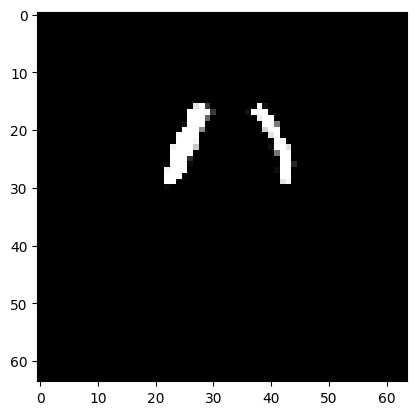

In [13]:
test_scan = utils.load_nifti_cbct_scan(PHOTOS_PATH+test[10]+"_0000.nii.gz")
test_scan = test_scan[..., np.newaxis]
test_scan = np.expand_dims(test_scan, axis=0)

predictions = model.predict(test_scan)

predicted_mask = predictions[0]

binary_mask = (predicted_mask > 0.5).astype(np.float32)

print(predicted_mask[25,:,:,0] == predicted_mask[30,:,:,0])

plt.imshow(predicted_mask[25, :, :, 0], cmap="gray")

Plot results

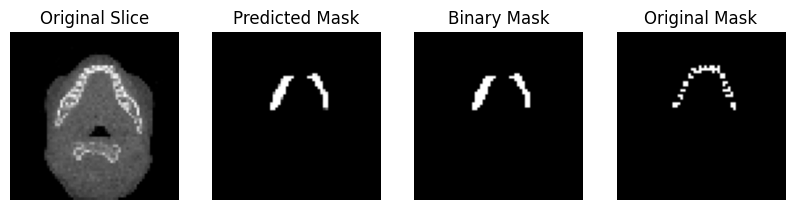

In [19]:
slice_index = 9

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(test_scan[0, slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Binary Mask")
plt.imshow(binary_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

original_mask = utils.load_nifti_mask(MASK_PATH+test[10]+".nii.gz")
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(original_mask[slice_index,:,:], cmap="gray")
plt.axis('off')
plt.show()